In [38]:
import datetime as dt

import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from src.common.data import DataGenerator

In [39]:
# Ensure SurRender is running
generator = DataGenerator.from_robbins_dataset(resolution=2048, diamlims=(30, 500), arc_lims=0)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [40]:
# Generate camera above Tycho (43.31°S 11.36°W) [https://en.wikipedia.org/wiki/Tycho_(lunar_crater)]

generator.set_coordinates(lat=-43.31, long=-11.36, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 2, 3, 12)
generator.height = 140
generator.point_nadir()
generator.solar_incidence_angle

69.68366967007213

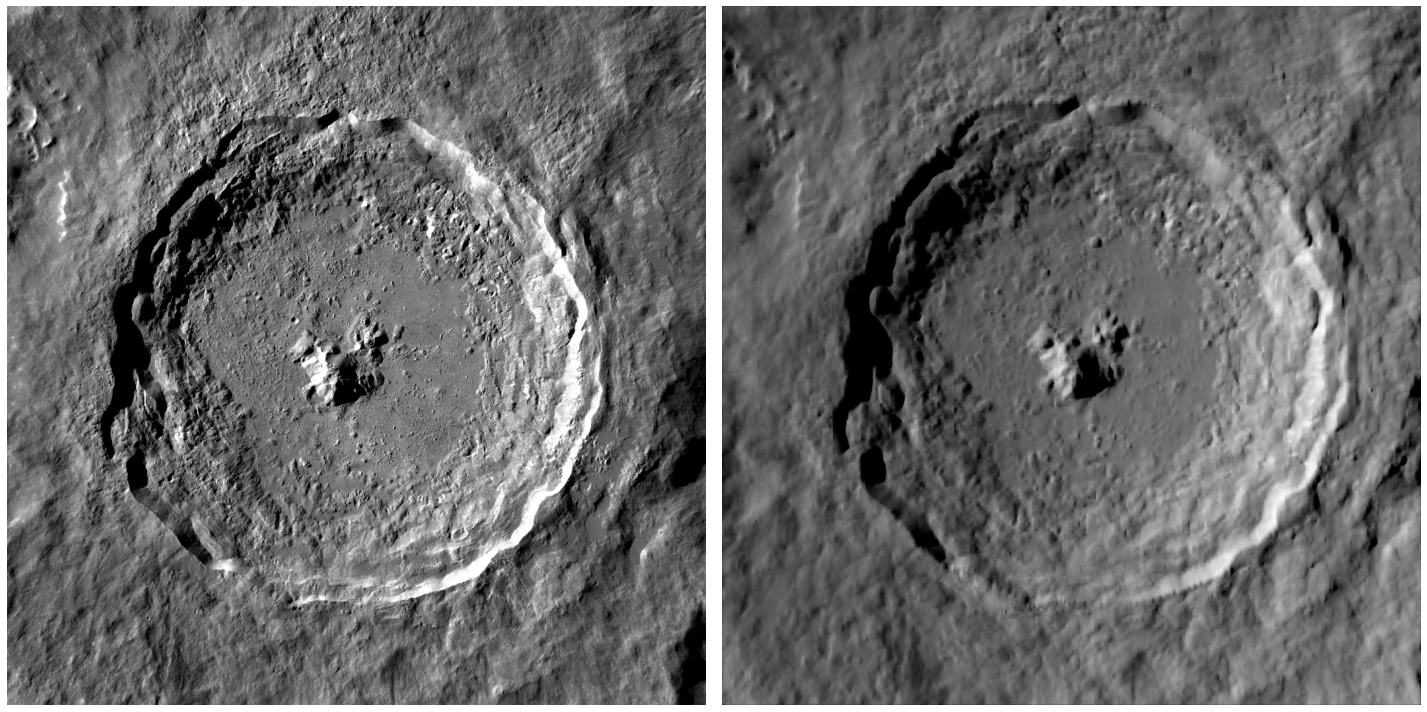

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

tycho_real = mpimg.imread('data/Tycho_LRO.png')
axes[0].imshow(tycho_real, cmap='gray')
axes[0].axis('off')

tycho_sim = generator.generate_image()
axes[1].imshow(tycho_sim, cmap='gray')
axes[1].axis('off')

fig.tight_layout()
# fig.savefig('diagrams/tycho_comparison.png')

In [42]:
# New scene
generator.set_coordinates(lat=0, long=180, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 3000
generator.point_nadir()
generator.solar_incidence_angle

72.11468853248124

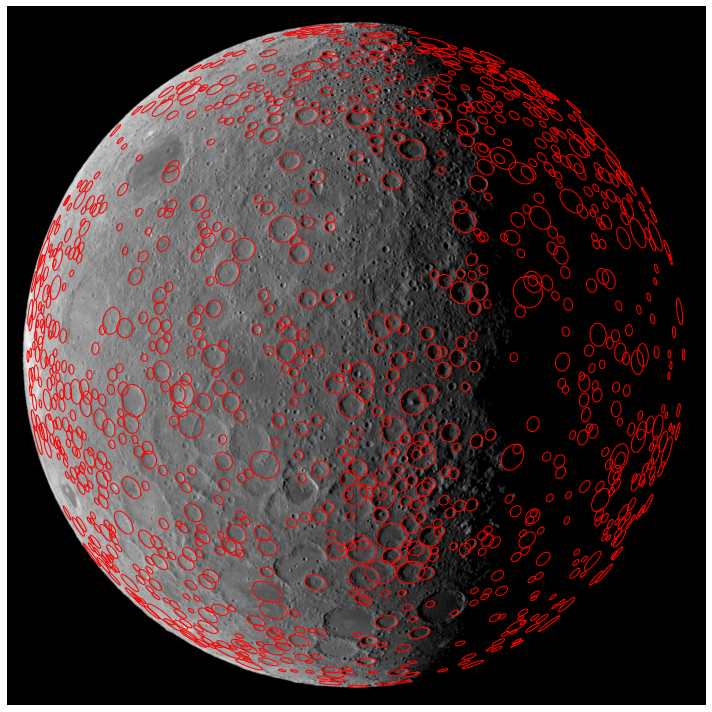

In [43]:
fig, ax= plt.subplots(figsize=(10, 10))

high_alt = generator.generate_image()
ax.imshow(high_alt, cmap='gray')
ax.axis('off')

generator.plot(ax=ax)

fig.tight_layout()
fig.savefig('diagrams/ellipse_plot_example.png')

In [48]:
generator = DataGenerator.from_robbins_dataset(resolution=512, diamlims=(15, 150), arc_lims=0, ellipse_limit=1.5)

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [49]:
generator.set_coordinates(lat=0, long=160, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 12)
generator.height = 500
generator.point_nadir()
generator.solar_incidence_angle

52.1188530140136

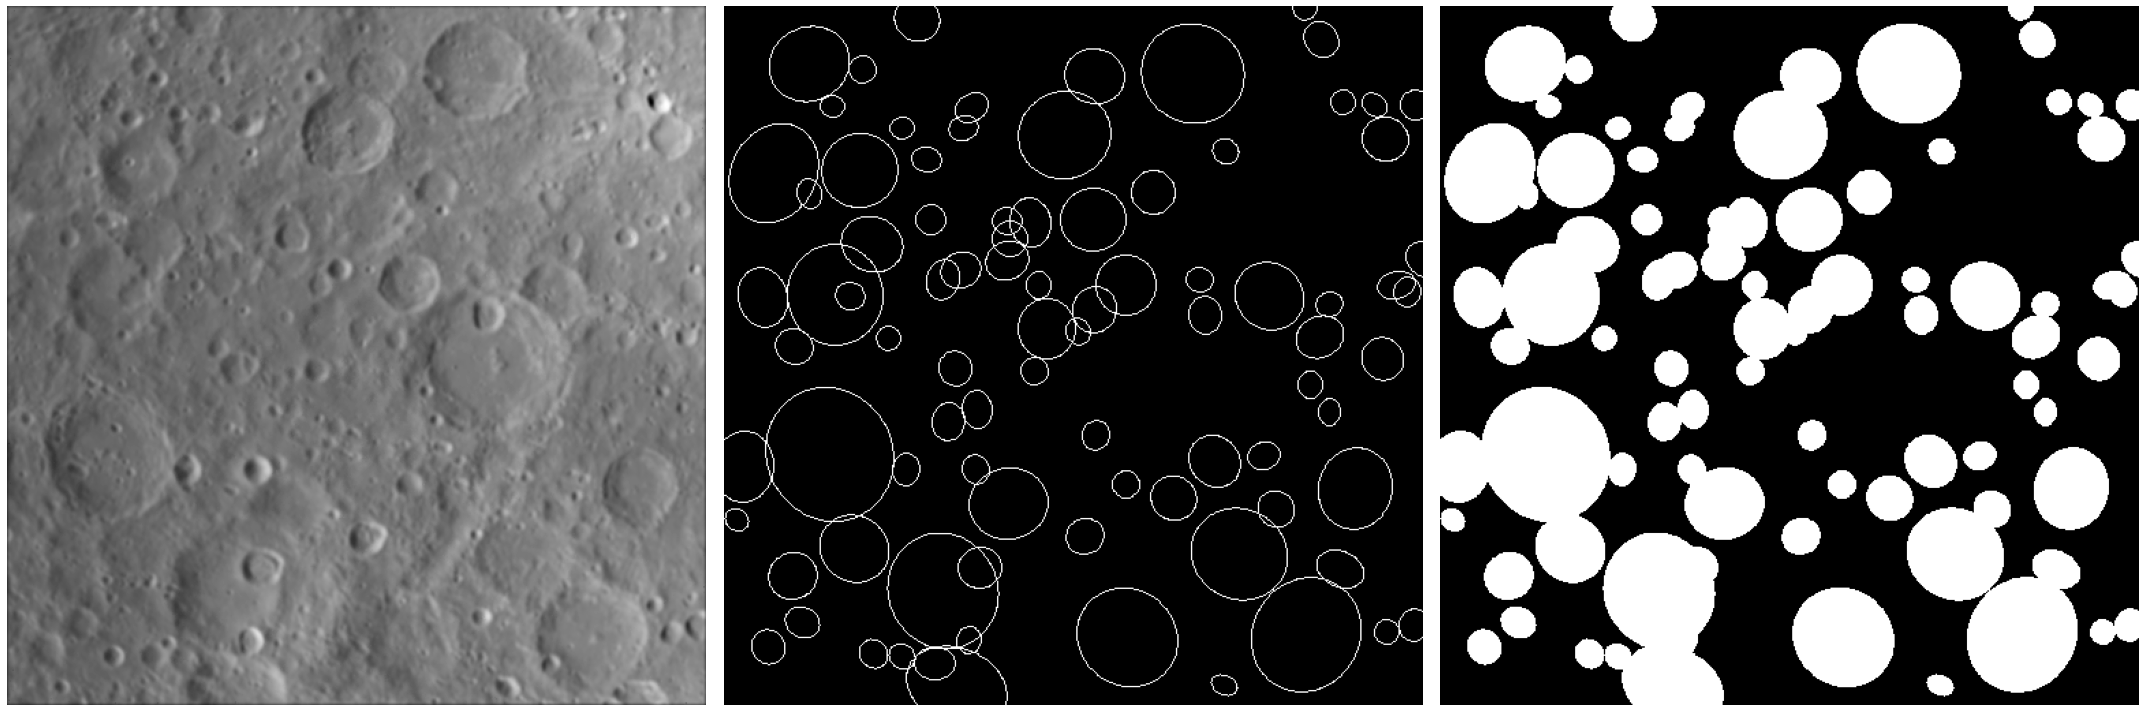

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

mask_demo_img, mask_edge = generator.image_mask_pair()
axes[0].imshow(mask_demo_img, cmap='gray')
axes[0].axis('off')


axes[1].imshow(mask_edge>0, cmap='gray')
axes[1].axis('off')

mask_filled = generator.generate_mask(filled=True)
axes[2].imshow(mask_filled>0, cmap='gray')
axes[2].axis('off')

fig.tight_layout()
fig.savefig('diagrams/image_mask_pair_demo.png')

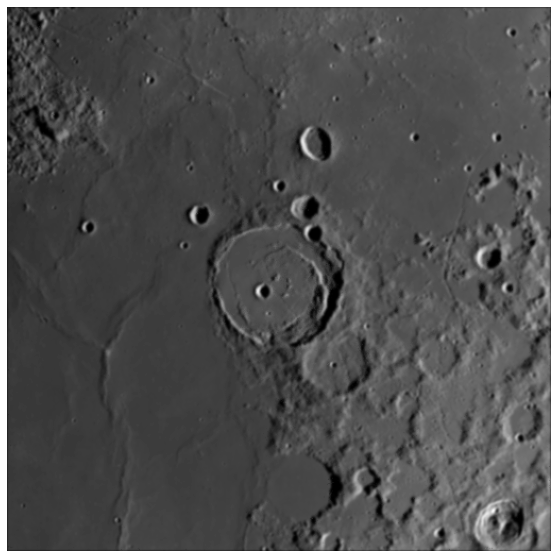

In [65]:
generator.set_coordinates(lat=32, long=30, convert_to_radians=True)
generator.scene_time = dt.datetime(2021, 1, 19, 19)
generator.height = 500
generator.point_nadir()

fig, ax = plt.subplots(figsize=(10, 10))

mask_demo_img = generator.generate_image()
ax.imshow(mask_demo_img, cmap='gray')
ax.axis('off')
fig.savefig("diagrams/crater_demo.png")

In [7]:
from src.detection.model import CraterDetector
from src.detection.training import CraterEllipseDataset, collate_fn
from torch.utils.data import DataLoader

import torch
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from common.conics import plot_conics, conic_center, scale_det, gaussian_angle_distance, mv_kullback_leibler_divergence

In [8]:
ds = CraterEllipseDataset(file_path="data/dataset_crater_detection.h5", group="test")
loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)
model = CraterDetector(backbone_name="resnet50")
checkpoint = mlflow.pytorch.load_state_dict(r'artifacts/1/748bb67f8cef46e1864101e26e2a151b/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cpu')

0.5728302597999573

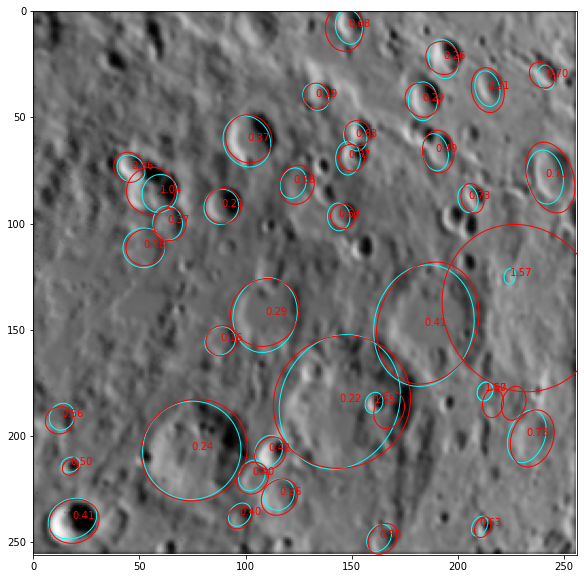

In [9]:
image, target = next(iter(loader))
model.eval()

A_craters_pred = model.get_conics(image, min_score=0.9)
A_craters_target = target[0]["ellipse_matrices"]

m_target = conic_center(target[0]["ellipse_matrices"])
m_pred = conic_center(A_craters_pred)

matched_idxs = torch.cdist(m_target, m_pred).argmin(0)

A_craters_target = A_craters_target[matched_idxs]
m_target = m_target[matched_idxs]

dist = gaussian_angle_distance(A_craters_target, A_craters_pred)
m1, m2 = map(lambda arr: torch.vstack(tuple(conic_center(arr).T)).T[..., None], (A_craters_pred, A_craters_target))

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image[0][0].numpy(), cmap='gray')
plot_conics(A_craters_target.numpy(), ax=ax, rim_color='cyan')
plot_conics(A_craters_pred.numpy(), ax=ax)

for pos, d in zip(m2.squeeze().numpy(), dist.numpy()):
    plt.text(*pos, f"{d:.2f}", color='red')

dist.mean().item()

In [6]:
# fig.savefig("output/detection_sample.png")

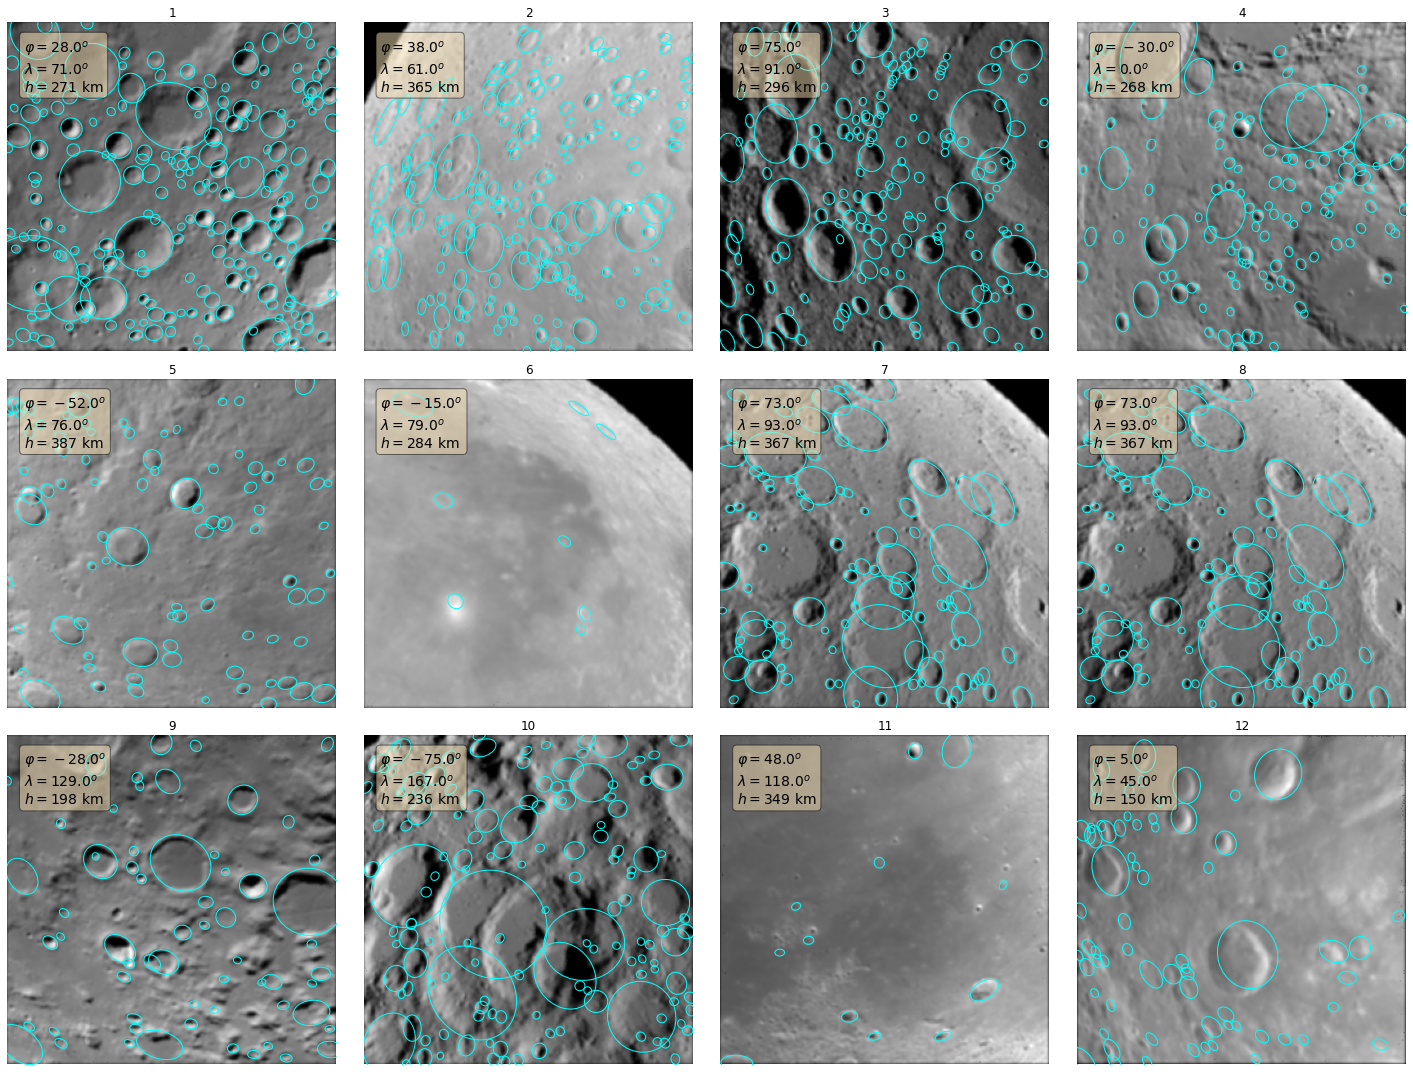

In [10]:
from astropy.coordinates import cartesian_to_spherical
import src.common.constants as const

n_rows, n_cols, i = 3, 4, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

for row in range(n_rows):
    for col in range(n_cols):
        image, target = next(iter(loader))
        A_craters_target = target[0]["ellipse_matrices"]
        position = target[0]["position"]
        attitude = target[0]["attitude"]
        r, lat, long = cartesian_to_spherical(*position.numpy())
        textstr = '\n'.join((
            rf'$\varphi={np.degrees(lat.value)[0]:.1f}^o$',
            rf'$\lambda={np.degrees(long.value)[0]-180:.1f}^o$',
            rf'$h={r.value[0]-const.RMOON:.0f}$ km',
        ))

        axes[row, col].imshow(image[0][0].numpy(), cmap='gray')
        axes[row, col].axis("off")
        axes[row, col].set_title(i)
        plot_conics(A_craters_target, ax=axes[row, col], rim_color='cyan')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[row, col].text(0.05, 0.95, textstr, transform=axes[row, col].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

        i += 1
fig.tight_layout()
# fig.savefig("diagrams/data_mosaic.png")

In [25]:
from src.matching import CraterDatabase
from src.common.surrender import SurRenderer
from astropy.coordinates import cartesian_to_spherical
import src.common.constants as const
import matplotlib.pyplot as plt
from src.detection import CraterDetector
from src.common.conics import plot_conics

import mlflow
import torch
import numpy.linalg as LA

In [15]:
model = CraterDetector(backbone_name="resnet50")
checkpoint = mlflow.pytorch.load_state_dict(r'artifacts/1/748bb67f8cef46e1864101e26e2a151b/artifacts/checkpoint')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device('cpu')

In [ ]:
db = CraterDatabase.from_file(diamlims=[5, 20], latlims=(-20, 20), longlims=(-20, 20))

lat, long, height = 5., 10., 150

renderer = SurRenderer.from_coordinates(lat, long, height, convert_to_radians=True)

Absolute error is 570.70m


C:\dev\workspace\crater-detection\src\matching\position_estimation.py:165: RuntimeWarning: invalid value encountered in sqrt
  (4 * np.sqrt(LA.det(Y_i) * LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
C:\dev\workspace\crater-detection\src\matching\position_estimation.py:166: RuntimeWarning: overflow encountered in exp
  * np.exp(-0.5 * (y_i - y_j).transpose(0, 1, 3, 2) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).squeeze()
C:\dev\workspace\crater-detection\src\common\conics.py:137: RuntimeWarning: invalid value encountered in sqrt
  axes = np.sqrt(1 / lambdas)


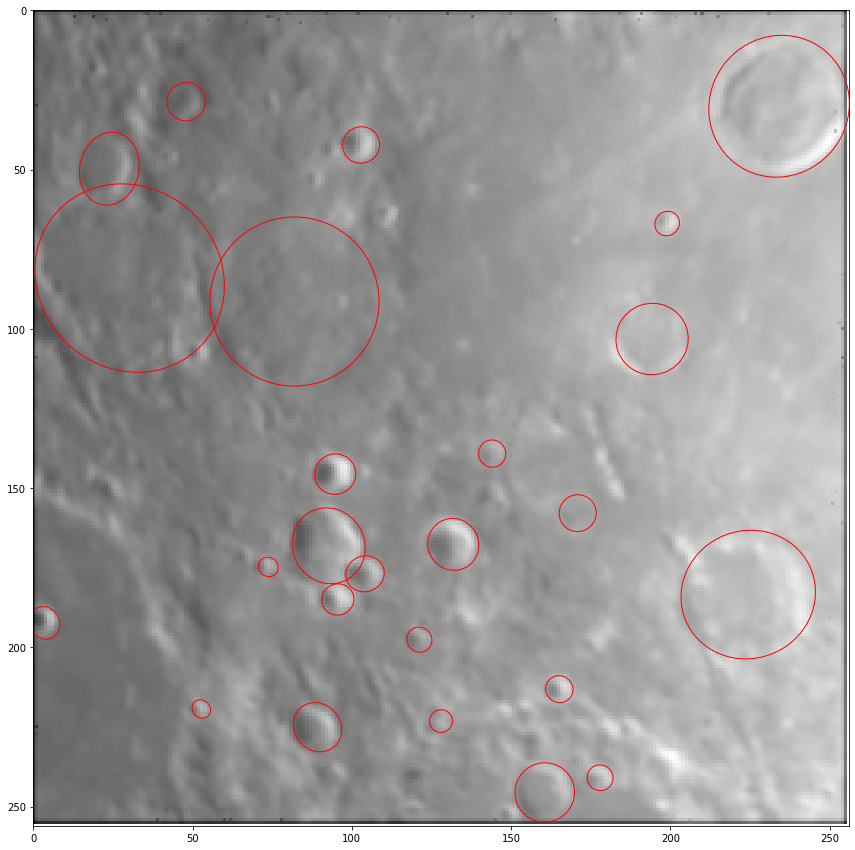

In [27]:
renderer.set_coordinates(-5, 4, 250, convert_to_radians=True)
image = renderer.generate_image()
A_craters_pred = model.get_conics(torch.tensor(image)[None, None, ...])
plot_conics(A_craters_pred)
plt.imshow(image, cmap='gray')
x_pred = db.query_position(A_craters_pred.numpy(), renderer.T, renderer.K)
x_true = renderer.position
err = x_pred - x_true
print(f"Absolute error is {LA.norm(err)*1e3:.2f}m")